In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from progressbar import ProgressBar
import time

%run ../global_variables.py ./
%run ../global_functions.py ./

This notebook compute 3 performance metrics (NSE, PBIAS and correlation) for given datasets and a selection of basins. Part 1 selects the basin, the datasets and run through all of them while saving results. Part 2 plots results.

<div class="alert alert-block alert-info">
There is no need to run Part 1, results are already saved. You can jump to part 2.2 to plot performance tabs, or to part 2.1 to plot particular cases
</div>

# 1. Run through datasets and selected basins

We select the basins we want to study. `NB_RUNOFF` is the number of runoff stations from [GRDC](https://www.bafg.de/SharedDocs/ExterneLinks/GRDC/grdc_stations_ftp.html) operating at least 1 year between 2003 and 2017, inside each basin.

In [3]:
approximate=True # 5 approximate climate zones, or 31 smaller ones 
basins=load_basins_data(approximate)

In [4]:
# we select basins larger than 65 000 km2 with at least 1 runoff station, or larger than 800,000 km2
selected_basins=basins.loc[((basins['RASTAREA']>=6.5e4)&(basins['NB_RUNOFF']>=1))|(basins['RASTAREA']>8e5),['COLOR','MAIN_CLIMATE','CLIMATE_AREA_%','RASTAREA','NB_RUNOFF','geometry']]

# remove Greenland and Antarctica if they have been selected
to_remove=['GREENLAND','ANTARCTICA']
for remove_basin in to_remove:
    if np.sum(selected_basins.index.isin([remove_basin]))>0:
        selected_basins.drop(remove_basin,inplace=True)

Nbasins=selected_basins.shape[0]
print("You selected {} basins, among which \n {} belong to equatorial zone \n {} to arid zone \n {} to warm temperate zone \n {} to snow zone \n {} to polar zone".format(Nbasins,
    selected_basins.loc[selected_basins['MAIN_CLIMATE']=='A'].shape[0],
    selected_basins.loc[selected_basins['MAIN_CLIMATE']=='B'].shape[0],
    selected_basins.loc[selected_basins['MAIN_CLIMATE']=='C'].shape[0],
    selected_basins.loc[selected_basins['MAIN_CLIMATE']=='D'].shape[0],
    selected_basins.loc[selected_basins['MAIN_CLIMATE']=='E'].shape[0]))

You selected 108 basins, among which 
 11 belong to equatorial zone 
 30 to arid zone 
 24 to warm temperate zone 
 43 to snow zone 
 0 to polar zone


We plot selected_basins

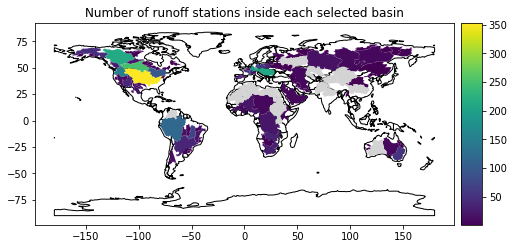

In [5]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

selected_basins_plot=selected_basins.copy()
selected_basins_plot['NB_RUNOFF']=np.where(selected_basins['NB_RUNOFF']==0,np.nan,selected_basins['NB_RUNOFF'])

fig, ax = plt.subplots(figsize=(8,5))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.plot(ax=ax, color='white', edgecolor='black')
selected_basins_plot.plot(ax=ax,column='NB_RUNOFF',legend=True,cax=cax,missing_kwds={"color": "lightgrey",})
ax.set_title("Number of runoff stations inside each selected basin")
plt.show()

List of datasets available for each hydrological variable

In [6]:
list_data_P=['CPC','TRMM']
list_data_ET=['GLDAS','SEB']
list_data_R=['GLDAS']
list_data_TWS=['GRACE_JPL']

## Computation for all hydrological datasets, over selected basins + performance metrics saved

Is it the first time we run the code with these parameters ?

In [7]:
first_time=True

We initialize the results dataframes

In [8]:
datasets=[]
for d_R in list_data_R:
    for d_P in list_data_P:
        for d_ET in list_data_ET:
            for d_TWS in list_data_TWS:
                datasets.append('R_{}_P_{}_ET_{}_TWS_{}'.format(d_R,d_P,d_ET,d_TWS))

In [9]:
if first_time:           
    df=selected_basins.copy()
    df[datasets]=np.nan*np.ones((selected_basins.shape[0],len(datasets)))
    correlation_tab=df.copy()
    PBIAS_tab=df.copy()
    NSE_tab=df.copy()
    
    correlation_tab.to_csv("../results/water_budget/correlation_tab_{}basins.csv".format(Nbasins))
    PBIAS_tab.to_csv("../results/water_budget/PBIAS_tab_{}basins.csv".format(Nbasins))
    NSE_tab.to_csv("../results/water_budget/NSE_tab_{}basins.csv".format(Nbasins))
else: # if we want to add new datasets to existing tabs
    correlation_tab=pd.read_csv("../results/water_budget/correlation_tab_{}basins.csv".format(Nbasins),index_col=[0])
    PBIAS_tab=pd.read_csv("../results/water_budget/PBIAS_tab_{}basins.csv".format(Nbasins),index_col=[0])
    NSE_tab=pd.read_csv("../results/water_budget/NSE_tab_{}basins.csv".format(Nbasins),index_col=[0])    

months were all variables are available

In [10]:
time_idx=pd.date_range(start='01-2003',end='1-2017',freq='SM')[::2]

In [20]:
i=0
for data_P in list_data_P:
    (spatial_grid,P_grid,time_P)=load_hydro_data('P',data_P,time_idx) # P serves as a reference grid
    
    for data_ET in list_data_ET:
        (spatial_grid_ET,ET_grid,time_ET)=load_hydro_data('ET',data_ET,time_idx)
        # check if ET has the same spatial grid as P
        same_ET=((spatial_grid['x']==spatial_grid_ET['x'])&(spatial_grid['y']==spatial_grid_ET['y'])).all()
        
        for data_R in list_data_R:
            (spatial_grid_R,R_grid,time_R)=load_hydro_data('R',data_R,time_idx)
            # check if R has the same spatial grid as P
            same_R=((spatial_grid['x']==spatial_grid_R['x'])&(spatial_grid['y']==spatial_grid_R['y'])).all()
        
            for data_TWS in list_data_TWS:
                (spatial_grid_TWS,TWS_grid,time_TWS)=load_hydro_data('TWS',data_TWS,time_idx)
                # check if TWS has the same spatial grid as P
                same_TWS=((spatial_grid['x']==spatial_grid_TWS['x'])&(spatial_grid['y']==spatial_grid_TWS['y'])).all()
        
                i+=1
                print("dataset {}/{}".format(i,len(datasets)))
                start_time = time.time()             
                
                pbar=ProgressBar()
                for basin_name in pbar(selected_basins.index):
                    my_basin=basins.loc[[basin_name],'geometry']
                    
                    # extract grid points for a given basin
                    final_selection=find_coordinates_inside_basin(my_basin,spatial_grid,basins)
                    
                    if same_ET: # if the grid is the same, we duplicate the reference grid
                        final_selection_ET=final_selection.copy()
                    else:
                        final_selection_ET=find_coordinates_inside_basin(my_basin,spatial_grid_ET,basins)
                        
                    if same_R:
                        final_selection_R=final_selection.copy()
                    else:
                        final_selection_R=find_coordinates_inside_basin(my_basin,spatial_grid_R,basins)
                    
                    if same_TWS:
                        final_selection_TWS=final_selection.copy()
                    else:
                        final_selection_TWS=find_coordinates_inside_basin(my_basin,spatial_grid_TWS,basins)

                    # select hydrological variables for the basin of interest
                    P_basin=P_grid.loc[final_selection.index]
                    ET_basin=ET_grid.loc[final_selection_ET.index]
                    R_basin=R_grid.loc[final_selection_R.index]
                    TWS_basin=TWS_grid.loc[final_selection_TWS.index]

                    # fill missing values
                    try:
                        P_basin=my_fillna(P_basin,'P',time_idx)
                    except:
                        col=['{} {}'.format('P',d.date()) for d in time_idx]
                        P_basin[col]=np.nan*P_basin[col]
                        
                    try:
                        ET_basin=my_fillna(ET_basin,'ET',time_idx)
                    except:
                        col=['{} {}'.format('ET',d.date()) for d in time_idx]
                        ET_basin[col]=np.nan*ET_basin[col]
                    
                    try:
                        R_basin=my_fillna(R_basin,'R',time_idx)
                    except:
                        col=['{} {}'.format('R',d.date()) for d in time_idx]
                        R_basin[col]=np.nan*R_basin[col]
                        
                    try:
                        TWS_basin=my_fillna(TWS_basin,'TWS',time_idx)
                    except:
                        col=['{} {}'.format('TWS',d.date()) for d in time_idx]
                        TWS_basin[col]=np.nan*TWS_basin[col]
                    
                    # if nans remain, it means that the basin is not covered by the datasets
                    nb_nan=P_basin[['{} {}'.format('P',d.date()) for d in time_idx]].isna().sum().sum()
                    nb_nan+=ET_basin[['{} {}'.format('ET',d.date()) for d in time_idx]].isna().sum().sum()
                    nb_nan+=R_basin[['{} {}'.format('R',d.date()) for d in time_idx]].isna().sum().sum()
                    nb_nan+=TWS_basin[['{} {}'.format('TWS',d.date()) for d in time_idx]].isna().sum().sum()
                    
                    if nb_nan==0: # if this basin is entirely covered by all datasets, proceed, otherwise the loop ends
                        # spatial average + filtering
                        P_filter=hydrological_variables_basin_filtered(P_basin,'P',time_idx,data_P)[1]
                        ET_filter=hydrological_variables_basin_filtered(ET_basin,'ET',time_idx,data_ET)[1]
                        R_filter=hydrological_variables_basin_filtered(R_basin,'R',time_idx,data_R)[1]
                        TWSC_filter=hydrological_variables_basin_filtered(TWS_basin,'TWS',time_idx,data_TWS)[1]

                        A_filter=P_filter-ET_filter-R_filter

                        # compute performance metrics
                        corr=A_filter.corr(TWSC_filter)
                        correlation_tab.loc[basin_name,'R_{}_P_{}_ET_{}_TWS_{}'.format(data_R,data_P,data_ET,data_TWS)]=corr

                        PBIAS=percentage_bias(A_filter,TWSC_filter)
                        PBIAS_tab.loc[basin_name,'R_{}_P_{}_ET_{}_TWS_{}'.format(data_R,data_P,data_ET,data_TWS)]=PBIAS

                        NSE=compute_NSE(A_filter,TWSC_filter)
                        NSE_tab.loc[basin_name,'R_{}_P_{}_ET_{}_TWS_{}'.format(data_R,data_P,data_ET,data_TWS)]=NSE
                    
                    #plot_water_budget(TWSC_filter,A_filter,basin_name,data_P,data_ET,data_R)
                print("--- %s seconds ---" % (time.time() - start_time))
       
    
correlation_tab.to_csv("../results/water_budget/correlation_tab_{}basins.csv".format(Nbasins))
PBIAS_tab.to_csv("../results/water_budget/PBIAS_tab_{}basins.csv".format(Nbasins))
NSE_tab.to_csv("../results/water_budget/NSE_tab_{}basins.csv".format(Nbasins))
first_time=False

dataset 1/4


100% |########################################################################|


--- 92.91473698616028 seconds ---


dataset 2/4


100% |########################################################################|


--- 90.57902193069458 seconds ---


dataset 3/4


100% |########################################################################|


--- 85.87478852272034 seconds ---


dataset 4/4


100% |########################################################################|


--- 85.29407501220703 seconds ---


# 2. Results

## 2.1 Water budget in a given basin, with a given dataset

In [13]:
def plot_water_budget(save_fig=False):
    TWSC_mean=TWSC_filter.mean()
    A_mean=A_filter.mean()
    plt.figure()
    plt.plot(TWSC_filter,'b',label='dTWS/dt mean={:.2f}'.format(TWSC_mean))
    plt.plot([TWSC_filter.index[0],TWSC_filter.index[-1]],[TWSC_mean,TWSC_mean],'b--',alpha=0.5)
    plt.plot(A_filter,'r',label='P-ET-R mean={:.2f}'.format(A_mean))
    plt.plot([A_filter.index[0],A_filter.index[-1]],[A_mean,A_mean],'r--',alpha=0.5)
    plt.legend()
    plt.title("Water budget equation in {} \n P {}, ET {}, R {} \n NSE={:.2f} PBIAS={:.2f} correlation={:.2f}".format(basin_name,
                                        data_P,data_ET,data_R,NSE,PBIAS,corr))
    plt.xlabel("month")
    plt.ylabel("mm")
    plt.xlim([date(2003,1,15),date(2017,1,15)])
    plt.tight_layout()
    
    if save_fig:
        plt.savefig("../plots/water_budget/{}_P_{}_ET_{}_R_{}.png".format(basin_name,
                                                data_P,data_ET,data_R))
    plt.show()
        
        
def plot_water_budget_details(save_fig=False):
    TWSC_mean=TWSC_filter.mean()
    plt.figure()
    plt.plot(TWSC_filter,'k--',label='dTWS/dt')
    plt.plot(P_filter,color='dodgerblue',label='P')
    plt.plot(P_filter-ET_filter,color='teal',label='P-ET')
    plt.plot(P_filter-ET_filter-R_filter,color='darkviolet',label='P-ET-R')
    
    plt.legend()
    plt.title("Water budget equation in {} \n P {}, ET {}, R {} \n NSE={:.2f} PBIAS={:.2f} correlation={:.2f}".format(basin_name,
                                        data_P,data_ET,data_R,NSE,PBIAS,corr))
    plt.xlabel("month")
    plt.ylabel("mm")
    plt.xlim([date(2003,1,15),date(2017,1,15)])
    plt.tight_layout()
    
    if save_fig:
        plt.savefig("../plots/water_budget/{}_P_{}_ET_{}_R_{}_details.png".format(basin_name,
                                                data_P,data_ET,data_R))
    plt.show()

In [7]:
approximate=True # 5 approximate climate zones, or 31 smaller ones 
basins=load_basins_data(approximate)

In [5]:
data_P='TRMM' # 'CPC','TRMM'
data_ET='GLDAS' # 'GLDAS','SEB'
data_R='GLDAS' # 'GLDAS','MERRA'
data_TWS='GRACE_JPL'

time_idx=pd.date_range(start='01-2003',end='1-2017',freq='SM')[::2]

(spatial_grid,P_grid,time_P)=load_hydro_data('P',data_P,time_idx)
(spatial_grid_R,R_grid,time_R)=load_hydro_data('R',data_R,time_idx)
same_R=((spatial_grid['x']==spatial_grid_R['x'])&(spatial_grid['y']==spatial_grid_R['y'])).all()

(spatial_grid_ET,ET_grid,time_ET)=load_hydro_data('ET',data_ET,time_idx)
same_ET=((spatial_grid['x']==spatial_grid_ET['x'])&(spatial_grid['y']==spatial_grid_ET['y'])).all()

(spatial_grid_TWS,TWS_grid,time_TWS)=load_hydro_data('TWS',data_TWS,time_idx)
same_TWS=((spatial_grid['x']==spatial_grid_TWS['x'])&(spatial_grid['y']==spatial_grid_TWS['y'])).all()

In basin LOIRE, correlation coefficient = 0.83 
 PBIAS = -24.01 
 NSE = 0.67


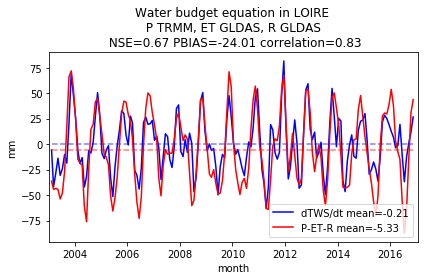

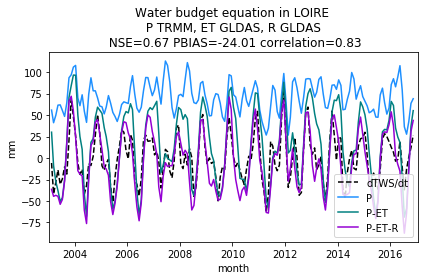

In [8]:
basin_name='LOIRE' # be aware to not choose a basin that is not covered by at least one selected dataset

my_basin=basins.loc[[basin_name],'geometry']
# extract grid points for a given basin
final_selection=find_coordinates_inside_basin(my_basin,spatial_grid,basins)

if same_ET: # if the grid is the same, we duplicate the reference grid
    final_selection_ET=final_selection.copy()
else:
    final_selection_ET=find_coordinates_inside_basin(my_basin,spatial_grid_ET,basins)

if same_R:
    final_selection_R=final_selection.copy()
else:
    final_selection_R=find_coordinates_inside_basin(my_basin,spatial_grid_R,basins)

if same_TWS:
    final_selection_TWS=final_selection.copy()
else:
    final_selection_TWS=find_coordinates_inside_basin(my_basin,spatial_grid_TWS,basins)


# select hydrological variables for the basin of interest
P_basin=P_grid.loc[final_selection.index]
ET_basin=ET_grid.loc[final_selection_ET.index]
R_basin=R_grid.loc[final_selection_R.index]
TWS_basin=TWS_grid.loc[final_selection_TWS.index]

# fill missing values
P_basin=my_fillna(P_basin,'P',time_idx)
ET_basin=my_fillna(ET_basin,'ET',time_idx)
R_basin=my_fillna(R_basin,'R',time_idx)
TWS_basin=my_fillna(TWS_basin,'TWS',time_idx)

# spatial average + filtering
P_filter=hydrological_variables_basin_filtered(P_basin,'P',time_idx,data_P)[1]
ET_filter=hydrological_variables_basin_filtered(ET_basin,'ET',time_idx,data_ET)[1]
R_filter=hydrological_variables_basin_filtered(R_basin,'R',time_idx,data_R)[1]
TWSC_filter=hydrological_variables_basin_filtered(TWS_basin,'TWS',time_idx,data_TWS)[1]

A_filter=P_filter-ET_filter-R_filter

# compute performance metrics
corr=A_filter.corr(TWSC_filter)
PBIAS=percentage_bias(A_filter,TWSC_filter)
NSE=compute_NSE(A_filter,TWSC_filter)

print("In basin {}, correlation coefficient = {:.2f} \n PBIAS = {:.2f} \n NSE = {:.2f}".format(basin_name,
                                    corr,PBIAS,NSE))


plot_water_budget()
plot_water_budget_details()

## 2.1 Performance metrics

White cases are shown in the performance tabs in each basin where at least 1 dataset is lacking. 

<div class="alert alert-block alert-warning">
The problem is that I cannot differentiate missing values from zero values (over arid regions for example).
</div>

In [25]:
def plot_performance_matrix(perf,perf_tab,xlim=-1.4,discrete=True,save_fig=False):
    nbA=perf_tab.loc[perf_tab['MAIN_CLIMATE']=='A'].shape[0]
    nbAB=nbA+perf_tab.loc[perf_tab['MAIN_CLIMATE']=='B'].shape[0]
    nbAC=nbAB+perf_tab.loc[perf_tab['MAIN_CLIMATE']=='C'].shape[0]
    nbAD=nbAC+perf_tab.loc[perf_tab['MAIN_CLIMATE']=='D'].shape[0]
    nbAE=nbAD+perf_tab.loc[perf_tab['MAIN_CLIMATE']=='E'].shape[0]
    
    norm,cmap=define_cmap_perf(perf,discrete=discrete)

    fig, ax = plt.subplots(figsize=(1.3*len(datasets),max(4,2.1*perf_tab.shape[0]//10)))
    im=ax.imshow(perf_tab[datasets],cmap=cmap,norm=norm,aspect='auto')
    if perf=='NSE': # from - inf to 1
        plt.colorbar(im, ax=ax,label=perf,fraction=0.05,extend='min')
    elif perf=='PBIAS': # from - inf to + inf
        plt.colorbar(im, ax=ax,label=perf,fraction=0.05,extend='both')
    else: # from -1 to 1
        plt.colorbar(im, ax=ax,label='correlation',fraction=0.05)
    
    if nbA>0:
        plt.plot([xlim,len(datasets)-0.5],[nbA-0.5,nbA-0.5],color=climate_color_dict['A'])
        plt.plot([-0.55,-0.55],[-0.5,nbA-0.5],color=climate_color_dict['A'])
    
    if nbAB>nbA:
        plt.plot([xlim,len(datasets)-0.5],[nbAB-0.5,nbAB-0.5],color=climate_color_dict['B'])
        plt.plot([-0.55,-0.55],[nbA-0.5,nbAB-0.5],color=climate_color_dict['B'])
    
    if nbAC>nbAB:
        plt.plot([xlim,len(datasets)-0.5],[nbAC-0.5,nbAC-0.5],color=climate_color_dict['C'])
        plt.plot([-0.55,-0.55],[nbAB-0.5,nbAC-0.5],color=climate_color_dict['C'])
    
    if nbAD>nbAC:
        plt.plot([xlim,len(datasets)-0.5],[nbAD-0.5,nbAD-0.5],color=climate_color_dict['D'])
        plt.plot([-0.55,-0.55],[nbAC-0.5,nbAD-0.5],color=climate_color_dict['D'])
        
    if nbAE>nbAD:
        plt.plot([-0.55,-0.55],[nbAD-0.5,Nbasins-0.5],color=climate_color_dict['E'])

    for i,nb_runoff in enumerate(perf_tab['NB_RUNOFF']):
        plt.text(xlim+0.1,i+0.3,nb_runoff,fontsize=8)
        
    if perf=='corr_basins':
        perf='correlation'

    ax.set_xticks([-1]+list(np.arange(len(datasets))))
    ax.set_yticks(np.arange(perf_tab.shape[0]))
    ax.set_yticklabels(perf_tab.index)
    ax.set_xticklabels(['number runoff stations']+list(datasets))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.xlim([xlim-0.07,len(datasets)-0.5])
    ax.set_title(perf)
    plt.tight_layout()
    
    if save_fig:
        plt.savefig('../plots/water_budget/{}_{}basins.png'.format(perf,Nbasins))
    plt.show()

### NSE

In [15]:
%matplotlib notebook

Nbasins=108
NSE_tab=pd.read_csv("../results/water_budget/NSE_tab_{}basins.csv".format(Nbasins),index_col=[0])
datasets=NSE_tab.columns
datasets=datasets.drop(['COLOR','MAIN_CLIMATE','CLIMATE_AREA_%','NB_RUNOFF','RASTAREA','geometry'])
NSE_tab.sort_values(by=['MAIN_CLIMATE','RASTAREA'],inplace=True)

NSE_tab['NB_RUNOFF']=NSE_tab['NB_RUNOFF'].astype(int)
NSE_tab['NB_RUNOFF_PER_KM2']=np.round(1e6*NSE_tab['NB_RUNOFF'].values/NSE_tab['RASTAREA'],1)

<IPython.core.display.Javascript object>


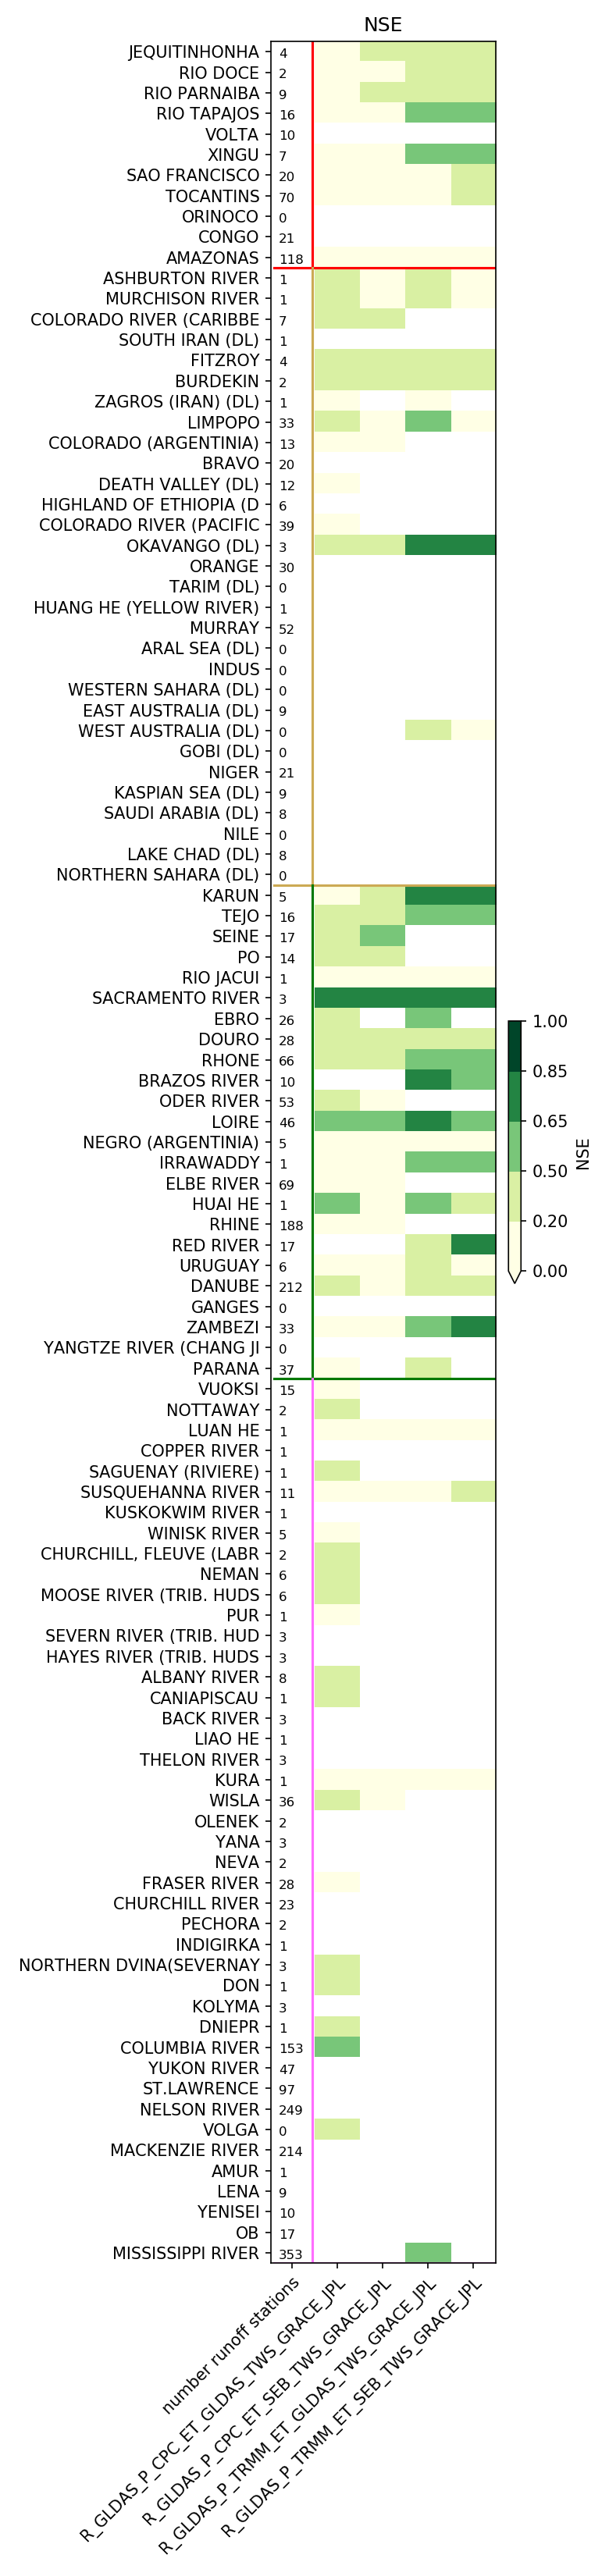

In [18]:
plot_performance_matrix('NSE',NSE_tab)

Correlation between NSE and
- basin area
- number of runoff stations
- number of runoff stations per $km^2$

In [19]:
param='RASTAREA' #'RASTAREA', 'NB_RUNOFF', 'NB_RUNOFF_PER_KM2'
NSE_corr=pd.DataFrame(np.nan*np.ones((5,len(datasets))),index=['A','B','C','D','all'],columns=datasets)

climate_list=['A','B','C','D']
for clim in climate_list:
    for d_set in datasets:
        NSE_tab_clim=NSE_tab.loc[NSE_tab['MAIN_CLIMATE']==clim] # basins in the corresponding cliamte area
        if NSE_tab_clim.shape[0]>=4: # we compute the correlation coefficient only if there are enough basins
            c=NSE_tab_clim[param].corr(NSE_tab_clim[d_set])
            NSE_corr.loc[clim,d_set]=c
        
for d_set in datasets:
    c=NSE_tab[param].corr(NSE_tab[d_set])
    NSE_corr.loc['all',d_set]=c

<IPython.core.display.Javascript object>


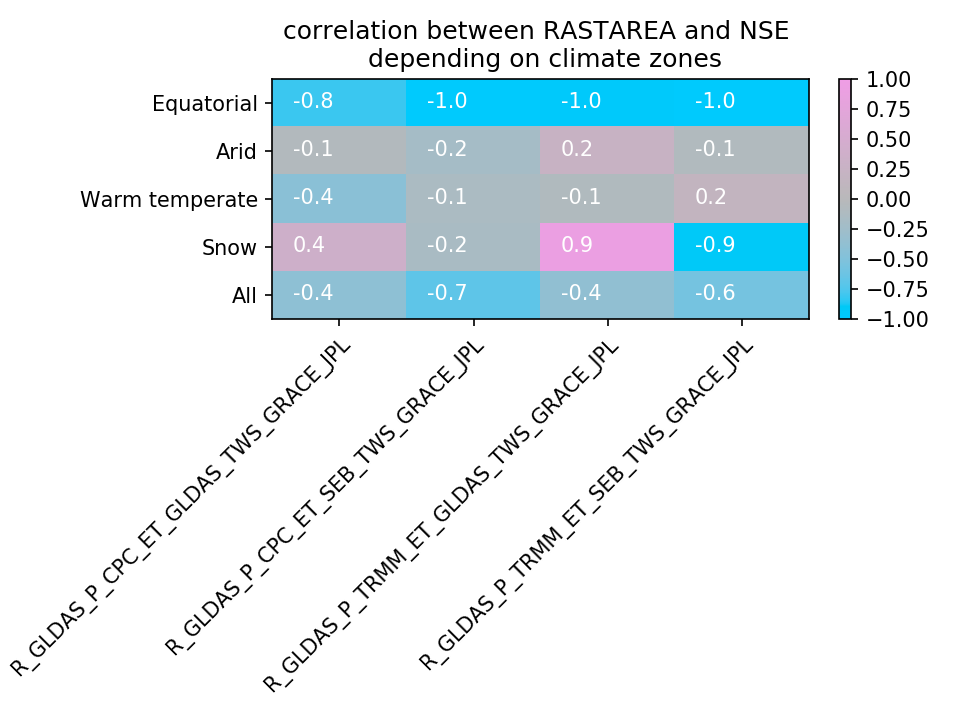

In [20]:
norm,cmap=define_cmap_perf('corr')

fig, ax = plt.subplots()
im=ax.imshow(NSE_corr,cmap=cmap,norm=norm,aspect='auto')
plt.colorbar(im, ax=ax,label='',fraction=0.05)

for i in range(NSE_corr.shape[0]):
    for j in range(NSE_corr.shape[1]):
        ax.text(j-0.35,i+0.1,'{:.1f}'.format(NSE_corr.iloc[i,j]),color='white')

ax.set_xticks(np.arange(len(datasets)))
ax.set_yticks(np.arange(5))
ax.set_yticklabels(['Equatorial','Arid','Warm temperate','Snow','All'])
ax.set_xticklabels(datasets)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
#plt.xlim([-0.58,len(datasets)-0.5])
ax.set_title("correlation between {} and NSE \n depending on climate zones".format(param))
plt.tight_layout()
plt.show()

### PBIAS

In [21]:
%matplotlib notebook

Nbasins=108
PBIAS_tab=pd.read_csv("../results/water_budget/PBIAS_tab_{}basins.csv".format(Nbasins),index_col=[0])
datasets=PBIAS_tab.columns
datasets=datasets.drop(['COLOR','MAIN_CLIMATE','CLIMATE_AREA_%','NB_RUNOFF','RASTAREA','geometry'])
PBIAS_tab.sort_values(by=['MAIN_CLIMATE','RASTAREA'],inplace=True)

PBIAS_tab['NB_RUNOFF']=PBIAS_tab['NB_RUNOFF'].astype(int)
PBIAS_tab['NB_RUNOFF_PER_KM2']=np.round(1e6*PBIAS_tab['NB_RUNOFF'].values/PBIAS_tab['RASTAREA'],1)

<IPython.core.display.Javascript object>


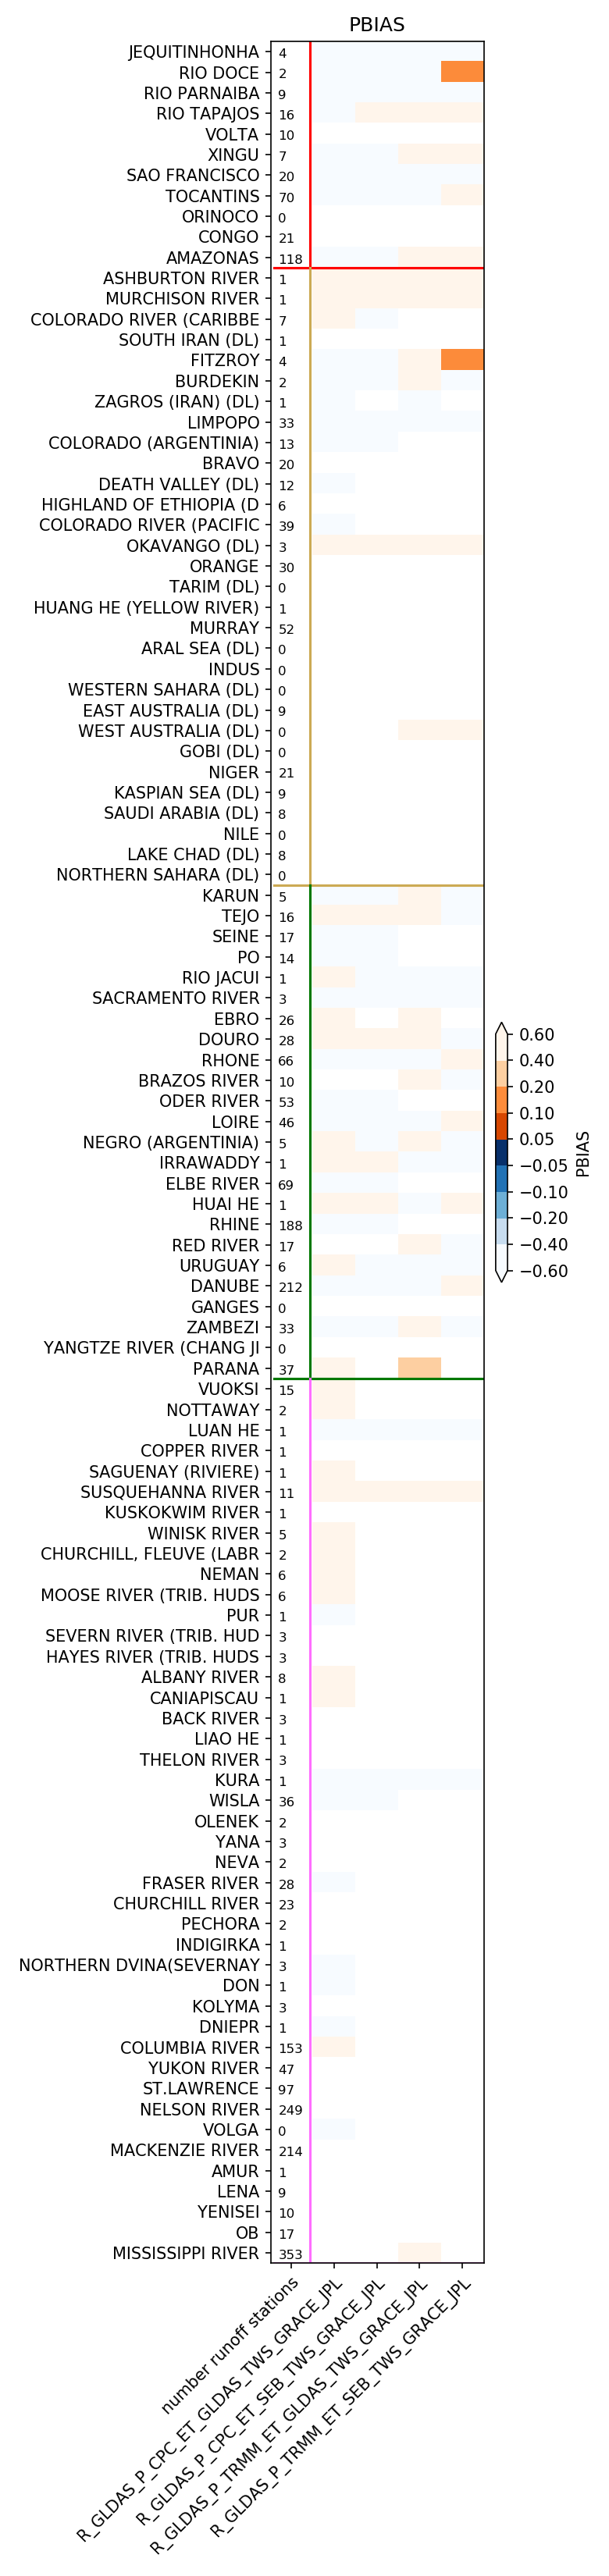

In [22]:
plot_performance_matrix('PBIAS',PBIAS_tab)

### Correlation

In [23]:
%matplotlib notebook

Nbasins=108
correlation_tab=pd.read_csv("../results/water_budget/correlation_tab_{}basins.csv".format(Nbasins),index_col=[0])
datasets=correlation_tab.columns
datasets=datasets.drop(['COLOR','MAIN_CLIMATE','CLIMATE_AREA_%','NB_RUNOFF','RASTAREA','geometry'])
correlation_tab.sort_values(by=['MAIN_CLIMATE','RASTAREA'],inplace=True)

correlation_tab['NB_RUNOFF']=correlation_tab['NB_RUNOFF'].astype(int)
correlation_tab['NB_RUNOFF_PER_KM2']=np.round(1e6*correlation_tab['NB_RUNOFF'].values/correlation_tab['RASTAREA'],1)

<IPython.core.display.Javascript object>


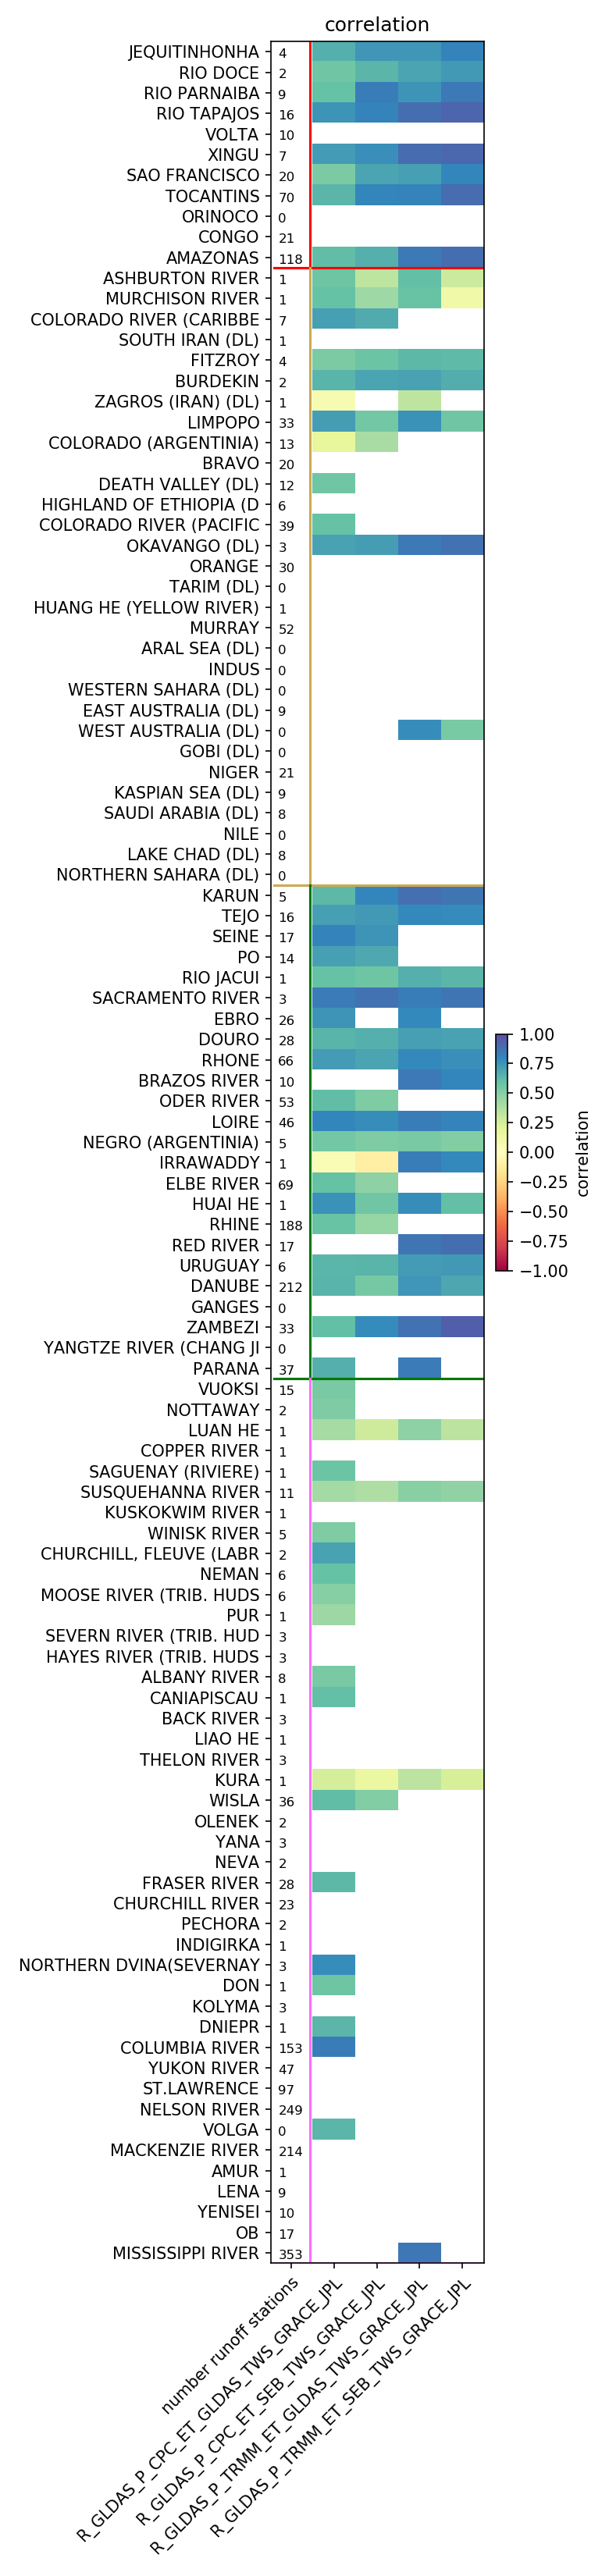

In [26]:
plot_performance_matrix('corr_basins',correlation_tab)